# Stroke Prediction Training Pipeline

This notebook implements a machine learning pipeline for stroke prediction with the following steps:
1. **Missing Value Handling** - Impute missing BMI values
2. **Preprocessing** - Scale numerical features and encode categorical features
3. **Balancing** - Apply SMOTE to address class imbalance
4. **Feature Selection** - Select most predictive features
5. **Model Training** - Train and evaluate models with cross-validation

**Important**: The original dataset is never modified - all transformations create copies.

## 1. Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load the dataset (original remains untouched)
df_original = pd.read_csv('data/stroke_data.csv')

# Create a working copy
df = df_original.copy()

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 5110 rows, 12 columns

First few rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Exploratory Data Analysis


In [3]:
# Dataset overview
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")

DATASET OVERVIEW

Shape: (5110, 12)

Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Data Types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [4]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})
print(missing_df)
print(f"\n⚠️ BMI has {missing['bmi']} missing values ({missing_pct['bmi']:.2f}%)")

MISSING VALUES
     Missing Count  Percentage
bmi            201    3.933464

⚠️ BMI has 201 missing values (3.93%)


In [5]:
# Class distribution - THE CRITICAL IMBALANCE
print("=" * 80)
print("CLASS DISTRIBUTION (TARGET VARIABLE)")
print("=" * 80)
print("\nAbsolute counts:")
print(df['stroke'].value_counts())
print("\nPercentages:")
print(df['stroke'].value_counts(normalize=True) * 100)

imbalance_ratio = df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]
print(f"\n⚠️ IMBALANCE RATIO: {imbalance_ratio:.2f}:1")
print(f"   - Only {(df['stroke'].sum() / len(df) * 100):.2f}% of cases are strokes!")

CLASS DISTRIBUTION (TARGET VARIABLE)

Absolute counts:
stroke
0    4861
1     249
Name: count, dtype: int64

Percentages:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

⚠️ IMBALANCE RATIO: 19.52:1
   - Only 4.87% of cases are strokes!


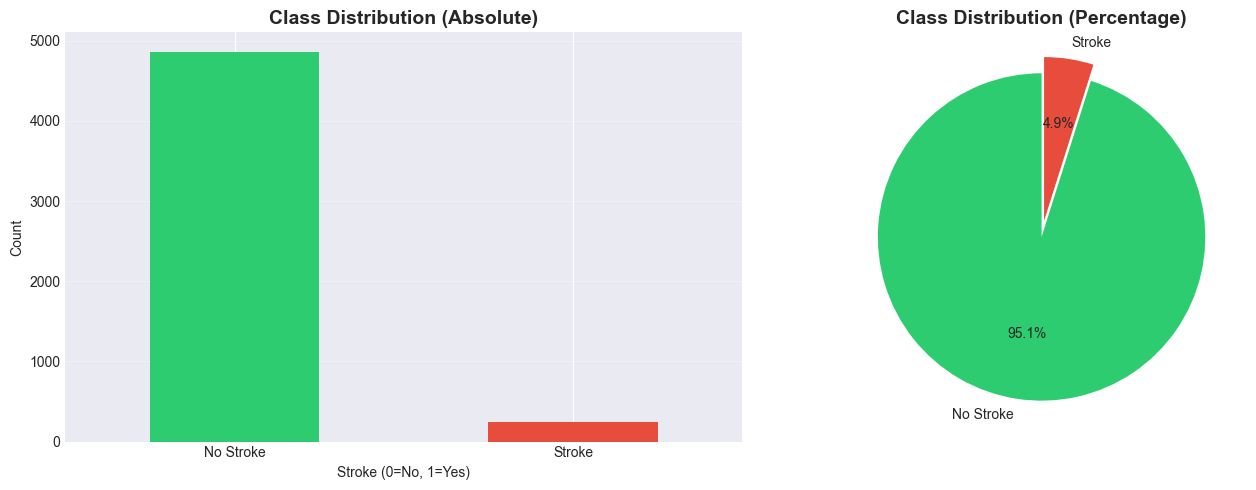

📊 Visualization shows severe class imbalance - SMOTE will be crucial!


In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['stroke'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Absolute)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)
df['stroke'].value_counts().plot(
    kind='pie', 
    ax=axes[1], 
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    labels=['No Stroke', 'Stroke'],
    startangle=90
)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"📊 Visualization shows severe class imbalance - SMOTE will be crucial!")

## 3. Data Preparation

### 3.1 Separate Features and Target

In [7]:
# Drop id column (non-predictive)
df_clean = df.drop('id', axis=1)

# Separate features and target
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

Features shape: (5110, 10)
Target shape: (5110,)

Features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


In [8]:
# Identify feature types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("=" * 80)
print("FEATURE TYPES")
print("=" * 80)
print(f"\nNumerical features ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")
    
print(f"\nCategorical features ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = X[col].nunique()
    print(f"  - {col} ({unique_vals} unique values)")

FEATURE TYPES

Numerical features (5):
  - age
  - hypertension
  - heart_disease
  - avg_glucose_level
  - bmi

Categorical features (5):
  - gender (3 unique values)
  - ever_married (2 unique values)
  - work_type (5 unique values)
  - Residence_type (2 unique values)
  - smoking_status (4 unique values)


## 4. Step 1: Missing Value Handling

We have 201 missing BMI values. We'll use median imputation (robust to outliers).

BMI ANALYSIS

BMI Statistics (excluding missing):
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


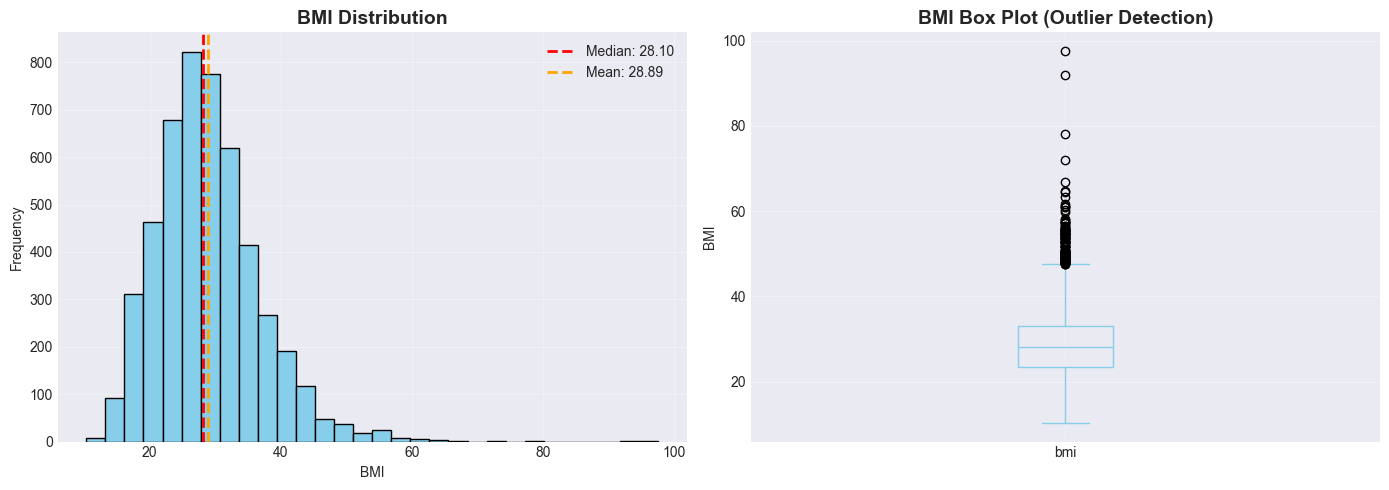


💡 Using MEDIAN (28.10) for imputation (robust to outliers)


In [9]:
# Analyze BMI distribution before imputation
print("=" * 80)
print("BMI ANALYSIS")
print("=" * 80)
print(f"\nBMI Statistics (excluding missing):")
print(X['bmi'].describe())

# Visualize BMI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
X['bmi'].dropna().hist(bins=30, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('BMI Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frequency')
axes[0].axvline(X['bmi'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {X["bmi"].median():.2f}')
axes[0].axvline(X['bmi'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {X["bmi"].mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
X['bmi'].dropna().plot(kind='box', ax=axes[1], color='skyblue')
axes[1].set_title('BMI Box Plot (Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('BMI')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Using MEDIAN ({X['bmi'].median():.2f}) for imputation (robust to outliers)")

In [10]:
# Create imputer for numerical features (specifically for BMI)
numerical_imputer = SimpleImputer(strategy='median')

# Apply imputation - create a copy to preserve X
X_imputed = X.copy()
X_imputed[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

print("=" * 80)
print("MISSING VALUE IMPUTATION RESULTS")
print("=" * 80)
print(f"\nBefore imputation:")
print(f"  BMI missing: {X['bmi'].isnull().sum()}")
print(f"\nAfter imputation:")
print(f"  BMI missing: {X_imputed['bmi'].isnull().sum()}")
print(f"\n✓ All missing values handled!")
print(f"\n📌 Imputed BMI value: {numerical_imputer.statistics_[numerical_cols.index('bmi')]:.2f}")

MISSING VALUE IMPUTATION RESULTS

Before imputation:
  BMI missing: 201

After imputation:
  BMI missing: 0

✓ All missing values handled!

📌 Imputed BMI value: 28.10


## 5. Step 2: Preprocessing (Scaling & Encoding)

We'll create separate transformers for numerical and categorical features, then combine them.

In [ ]:
# Create preprocessing pipeline
print("=" * 80)
print("BUILDING PREPROCESSING PIPELINE")
print("=" * 80)

# Numerical preprocessing: Imputation + Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print(f"\n✓ Preprocessing pipeline created:")
print(f"  - Numerical: {len(numerical_cols)} features → Imputation + StandardScaler")
print(f"  - Categorical: {len(categorical_cols)} features → OneHotEncoder")

In [11]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
num_feature_names = numerical_cols
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = num_feature_names + list(cat_feature_names)

print("=" * 80)
print("PREPROCESSING RESULTS")
print("=" * 80)
print(f"\nOriginal feature count: {X.shape[1]}")
print(f"After preprocessing: {X_preprocessed.shape[1]}")
print(f"\nFeature expansion breakdown:")
print(f"  - Numerical features: {len(numerical_cols)} (unchanged)")
print(f"  - Categorical features: {len(categorical_cols)} → {len(cat_feature_names)} (after one-hot encoding)")
print(f"\n✓ All features scaled and encoded!")
print(f"\nNew feature names (first 15):")
for i, name in enumerate(all_feature_names[:15], 1):
    print(f"  {i}. {name}")
if len(all_feature_names) > 15:
    print(f"  ... and {len(all_feature_names) - 15} more")

NameError: name 'preprocessor' is not defined

In [ ]:
# Verify preprocessing: check if features are scaled (mean ≈ 0, std ≈ 1 for numerical)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

print("=" * 80)
print("VERIFICATION: NUMERICAL FEATURES SCALED CORRECTLY")
print("=" * 80)
print("\nNumerical features after scaling (should have mean ≈ 0, std ≈ 1):")
for col in numerical_cols:
    mean = X_preprocessed_df[col].mean()
    std = X_preprocessed_df[col].std()
    print(f"  {col:20s} - Mean: {mean:7.4f}, Std: {std:.4f}")

print("\n✓ Preprocessing verified successfully!")

## 6. Step 3: Class Balancing with SMOTE

Now we'll apply SMOTE to create synthetic samples of the minority class (stroke=1).

**Important**: SMOTE should only be applied to training data during cross-validation to prevent data leakage!
For demonstration purposes, we'll show the effect here, but in the actual training loop, SMOTE will be applied within each CV fold.

In [ ]:
# Split data first (IMPORTANT: SMOTE only on training set)
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution in split
)

print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

In [ ]:
# Apply SMOTE to training data only
print("=" * 80)
print("APPLYING SMOTE TO TRAINING DATA")
print("=" * 80)

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)

print("\nBefore SMOTE:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Class 0 (No Stroke): {(y_train == 0).sum()}")
print(f"  Class 1 (Stroke): {(y_train == 1).sum()}")
print(f"  Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"  Training samples: {X_train_balanced.shape[0]}")
print(f"  Class 0 (No Stroke): {(y_train_balanced == 0).sum()}")
print(f"  Class 1 (Stroke): {(y_train_balanced == 1).sum()}")
print(f"  Imbalance ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")

print(f"\n✓ SMOTE created {(y_train_balanced == 1).sum() - (y_train == 1).sum()} synthetic stroke samples!")
print(f"⚠️ Test set remains unchanged (imbalanced) for realistic evaluation")

In [ ]:
# Visualize the effect of SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train_counts = pd.Series(y_train).value_counts()
y_train_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Training Data BEFORE SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(y_train_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# After SMOTE
y_balanced_counts = pd.Series(y_train_balanced).value_counts()
y_balanced_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Training Data AFTER SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stroke (0=No, 1=Yes)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(y_balanced_counts):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Dataset is now balanced for training!")